# RealSense Frame - Getting Started

This notebook demonstrates how to use `realsense-frame` to load captured RGB-D sessions, align depth to color using camera extrinsics, and export colored point clouds for 3D reconstruction.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlouielu/realsense-frame/blob/main/notebooks/getting_started.ipynb)

## 1. Setup

Clone the repo and install. The `example/` directory contains sample data ready to use.

In [ ]:
!git clone https://github.com/mlouielu/realsense-frame.git
%cd realsense-frame
!pip install -q .

## 2. Load Sample Data

In [9]:
from pathlib import Path

# On Colab (after git clone + cd above), sample data is already here:
DATA_DIR = Path("example") / "sample_capture"

# When running locally from notebooks/:
#DATA_DIR = Path("..") / "example" / "sample_capture"

## 3. Load a Session

In [2]:
import glob
from realsense_frame.loader import SessionLoader

# Find the first session in sample_capture/
sessions = sorted(DATA_DIR.glob("**/session_*"))
print(f"Found {len(sessions)} session(s):")
for s in sessions:
    print(f"  {s}")

SESSION_PATH = str(sessions[0])
loader = SessionLoader(SESSION_PATH)

print(f"\nUsing: {SESSION_PATH}")
print(f"Frames: {len(loader)}")
print(f"Alignment target: {loader.align_target}")
print(f"Has extrinsics: {loader.aligner and loader.aligner.extrinsics is not None}")

Found 1 session(s):
  ../example/sample_capture/session_20260206_140243

Using: ../example/sample_capture/session_20260206_140243
Frames: 6
Alignment target: color
Has extrinsics: True


## 4. Inspect a Frame

In [3]:
import numpy as np

frame = loader.get_frame(0)

print(f"Timestamp: {frame.timestamp}")
print(f"Color:  {frame.color.shape}, dtype={frame.color.dtype}")
print(f"Depth:  {frame.depth.shape}, dtype={frame.depth.dtype}")
if frame.infra1 is not None and not getattr(frame.infra1, '_is_placeholder', True):
    print(f"Infra1: {frame.infra1.shape}")
if frame.imu_samples:
    print(f"IMU samples: {len(frame.imu_samples)}")
print(f"Depth units: {frame.metadata.get('depth_units', 'N/A')}")

Timestamp: 2026-02-06T14:02:50.406590
Color:  (720, 1280, 3), dtype=uint8
Depth:  (720, 1280), dtype=uint16
Infra1: (720, 1280)
IMU samples: 200
Depth units: 0.0010000000474974513


## 5. Visualize RGB and Depth

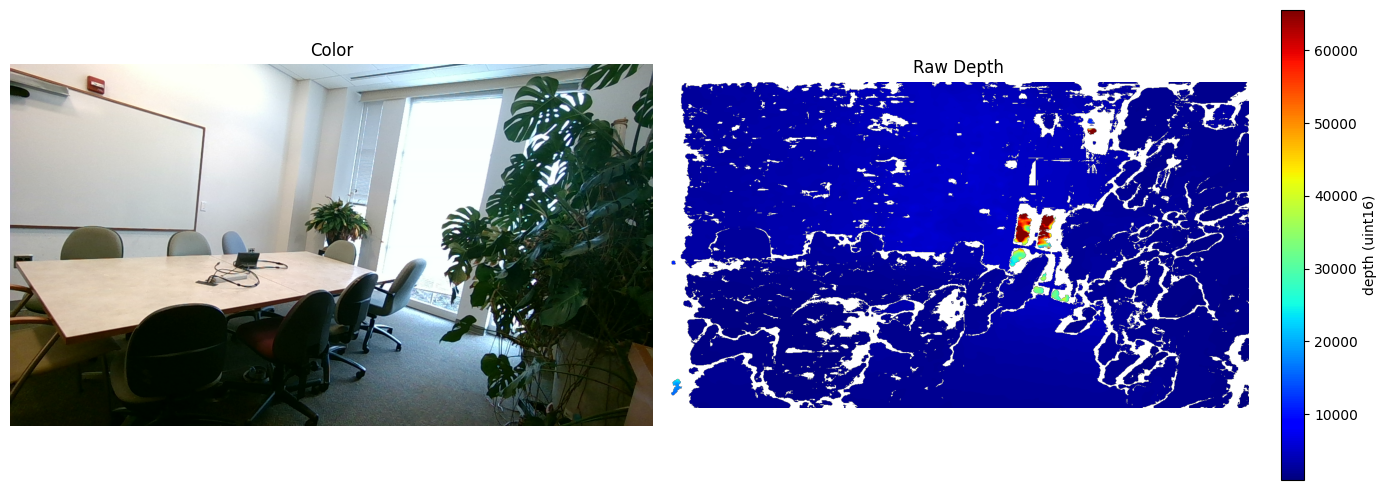

In [4]:
import cv2
import matplotlib.pyplot as plt

def show_depth(depth_img, ax, title="Depth"):
    """Display depth as a colormap."""
    d = np.asanyarray(depth_img).astype(np.float32)
    d[d == 0] = np.nan  # mask invalid
    im = ax.imshow(d, cmap="jet")
    ax.set_title(title)
    ax.axis("off")
    return im

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color (BGR -> RGB for matplotlib)
axes[0].imshow(cv2.cvtColor(frame.color, cv2.COLOR_BGR2RGB))
axes[0].set_title("Color")
axes[0].axis("off")

# Depth
im = show_depth(frame.depth, axes[1], "Raw Depth")
plt.colorbar(im, ax=axes[1], fraction=0.046, label="depth (uint16)")

plt.tight_layout()
plt.show()

## 5.1 Interactive Frame Browser

Use the slider to browse through all frames in the session.

In [5]:
import ipywidgets as widgets
from IPython.display import display

def browse_frame(idx):
    f = loader.get_frame(idx)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].imshow(cv2.cvtColor(f.color, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Color - Frame {idx}")
    axes[0].axis("off")

    show_depth(f.depth, axes[1], f"Depth - Frame {idx}")
    plt.tight_layout()
    plt.show()

slider = widgets.IntSlider(
    value=0, min=0, max=len(loader) - 1, step=1,
    description="Frame:", continuous_update=False,
)
widgets.interact(browse_frame, idx=slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame:', max=5), Output()), _do…

<function __main__.browse_frame(idx)>

## 6. Depth-to-Color Alignment

The loader automatically uses extrinsics (if present in `config.json`) for proper alignment.
`frame.d2c()` aligns the depth image to the color camera viewpoint.

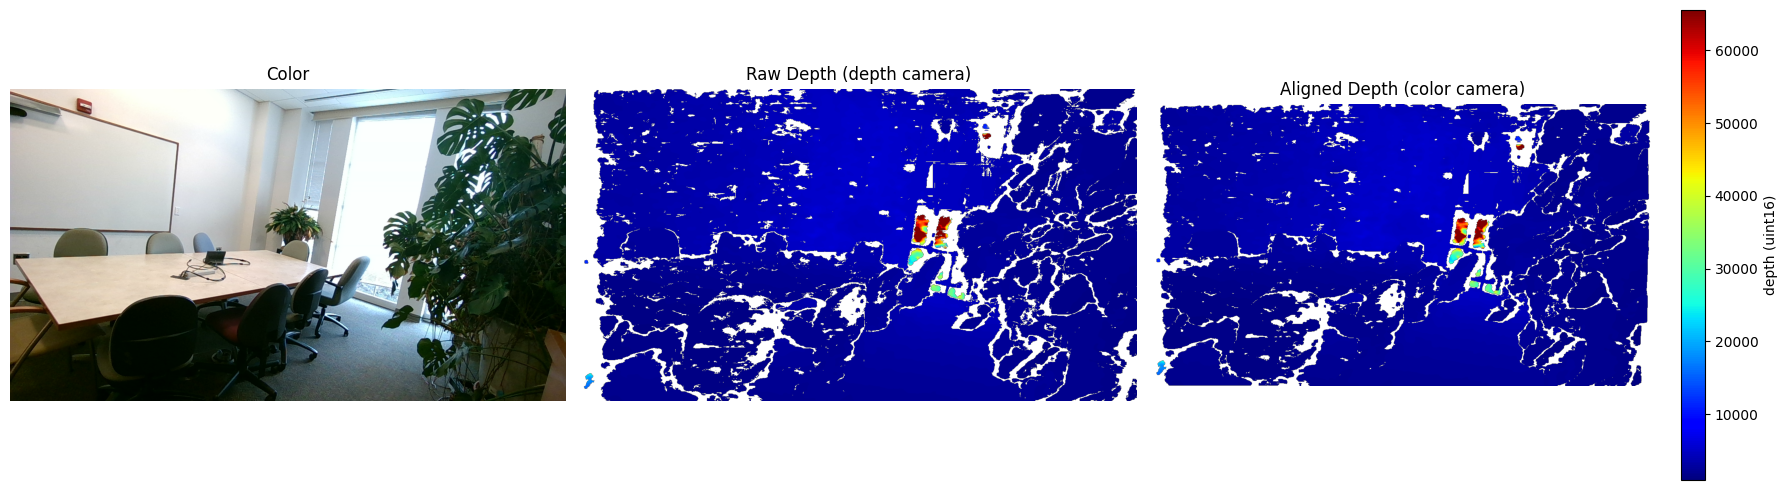

In [6]:
aligned_depth = frame.d2c()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Color
axes[0].imshow(cv2.cvtColor(frame.color, cv2.COLOR_BGR2RGB))
axes[0].set_title("Color")
axes[0].axis("off")

# Raw depth (resized to color resolution for comparison)
show_depth(frame.depth, axes[1], "Raw Depth (depth camera)")

# Aligned depth
im = show_depth(aligned_depth, axes[2], "Aligned Depth (color camera)")
plt.colorbar(im, ax=axes[2], fraction=0.046, label="depth (uint16)")

plt.tight_layout()
plt.show()

## 6.1 Alignment Comparison: With vs Without Extrinsics

A 2x2 grid comparing alignment quality. The extrinsics encode the physical offset between the depth and color cameras (~59mm on a D435). Without extrinsics, depth edges won't match color edges properly.

In [7]:
from realsense_frame.utils import RealSenseAligner

intrinsics = loader.get_intrinsics()
d_intr = intrinsics["depth"]
c_intr = intrinsics["color"] or intrinsics["infra1"]

# Build a no-extrinsics aligner for comparison
aligner_no_ext = RealSenseAligner(c_intr, d_intr, extrinsics=None)

def compare_alignment(idx):
    f = loader.get_frame(idx)
    target = f.color if f.color is not None else f.infra1
    scale = f.metadata.get("depth_units", 0.001)

    aligned_no_ext = aligner_no_ext.align(f.depth, target, scale)
    aligned_ext = f.d2c()  # uses extrinsics from config

    def to_overlay(depth_img):
        vis = cv2.applyColorMap(
            cv2.convertScaleAbs(np.asanyarray(depth_img), alpha=0.03),
            cv2.COLORMAP_JET,
        )
        vis = cv2.resize(vis, (target.shape[1], target.shape[0]))
        return cv2.addWeighted(np.asanyarray(target), 0.7, vis, 0.3, 0)

    raw_vis = cv2.applyColorMap(
        cv2.convertScaleAbs(np.asanyarray(f.depth), alpha=0.03),
        cv2.COLORMAP_JET,
    )
    raw_overlay = cv2.addWeighted(
        np.asanyarray(target), 0.7,
        cv2.resize(raw_vis, (target.shape[1], target.shape[0])), 0.3, 0,
    )

    # 2x2 grid: RGB, Unaligned, Aligned (no ext), Aligned (ext)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    axes[0, 0].imshow(cv2.cvtColor(np.asanyarray(target), cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title("RGB", fontsize=14)
    axes[0, 0].axis("off")

    axes[0, 1].imshow(cv2.cvtColor(raw_overlay, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title("Unaligned", fontsize=14)
    axes[0, 1].axis("off")

    axes[1, 0].imshow(cv2.cvtColor(to_overlay(aligned_no_ext), cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title("Aligned (no extrinsics)", fontsize=14, color="red")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(cv2.cvtColor(to_overlay(aligned_ext), cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title("Aligned (with extrinsics)", fontsize=14, color="green")
    axes[1, 1].axis("off")

    plt.suptitle(f"Frame {idx} - Alignment Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()

slider = widgets.IntSlider(
    value=0, min=0, max=len(loader) - 1, step=1,
    description="Frame:", continuous_update=False,
)
widgets.interact(compare_alignment, idx=slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame:', max=5), Output()), _do…

<function __main__.compare_alignment(idx)>

## 7. Overlay: Depth on Color

Overlaying aligned depth on the color image shows how well the alignment works.
Edges in the depth should match edges in the color image.

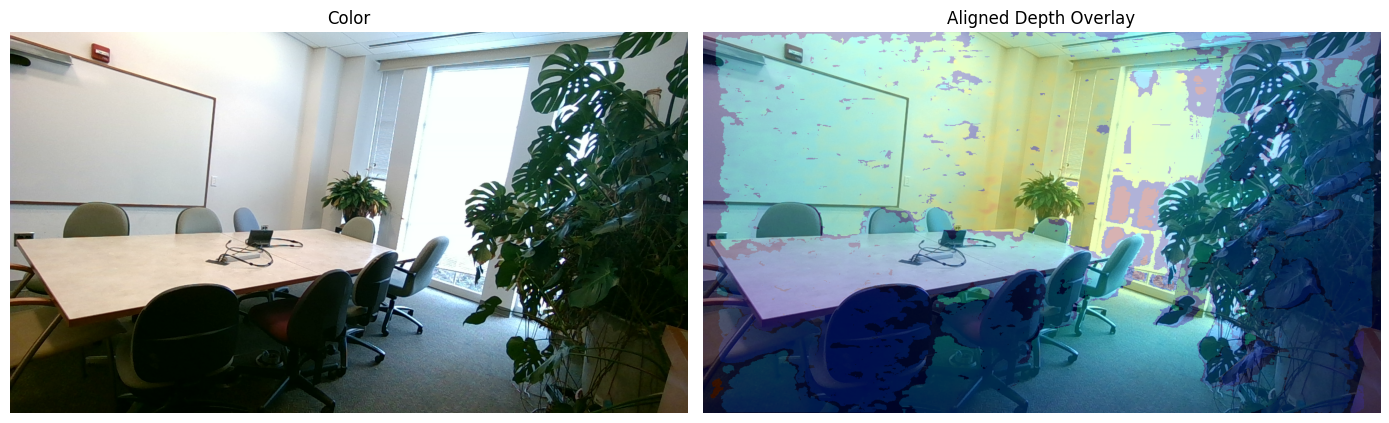

In [8]:
def depth_to_colormap(depth_img):
    return cv2.applyColorMap(
        cv2.convertScaleAbs(np.asanyarray(depth_img), alpha=0.03),
        cv2.COLORMAP_JET,
    )

h, w = frame.color.shape[:2]
aligned_vis = depth_to_colormap(aligned_depth)
aligned_vis = cv2.resize(aligned_vis, (w, h))
overlay = cv2.addWeighted(frame.color, 0.7, aligned_vis, 0.3, 0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(cv2.cvtColor(frame.color, cv2.COLOR_BGR2RGB))
axes[0].set_title("Color")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
axes[1].set_title("Aligned Depth Overlay")
axes[1].axis("off")

plt.tight_layout()
plt.show()